# Flight Performance in US
## by Saurabh Kulkarni

## Investigation Overview

> The goal of the investigation is to dive deeper into flight performance data to understand the underlying factors causing flight delays as well as present carrier performance in terms of cancellations and delays. 

## Dataset Overview

> The dataset is from Bureau of Transportation Statistics. It contains information about delays and cancellations for different carriers and destinations. This dataset has been retrieved from their official website in CSV format. The dataset has been retrieved for three years period, from 2006 to 2008. 

In [17]:
# import all packages and set plots to be embedded inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
import requests
import matplotlib.patches as mpatches
%matplotlib inline

# suppress warnings from final output
import warnings
warnings.simplefilter("ignore")

In [2]:
# load in the dataset into a pandas dataframe
#Read CSV files for years 2006,2007 and 2008 into individual dataframes
df_2008=pd.read_csv('2008.csv')
df_2007=pd.read_csv('2007.csv')
df_2006=pd.read_csv('2006.csv')
#Append all three dataframes and save into master df
df_data=df_2006.append([df_2007,df_2008])

In [3]:
#Changing column names to make it more meaningful and usable in later stages
df_data=df_data.rename(columns={'Year':'year','Month':'month','DayofMonth':'day_of_month','DayOfWeek':'day_of_week','DepTime':'actual_dep_time','CRSDepTime':'crs_dep_time','ArrTime':'actual_arr_time','CRSArrTime':'crs_arr_time','UniqueCarrier':'unique_carrier_code','FlightNum':'flight_number','TailNum':'tail_number','ActualElapsedTime':'actual_elapsed_time','CRSElapsedTime':'crs_elapsed_time','AirTime':'flight_time','ArrDelay':'arrival_delay','DepDelay':'departure_delay','Origin':'origin','Dest':'destination','Distance':'distance','TaxiIn':'taxi_in_time','TaxiOut':'taxi_out_time','Cancelled':'cancelled','CancellationCode':'cancellation_code','Diverted':'diverted','CarrierDelay':'carrier_delay','WeatherDelay':'weather_delay','NASDelay':'nas_delay','SecurityDelay':'security_delay','LateAircraftDelay':'late_aircraft_delay'})


(21604865, 29)

## What are the biggest reasons for cancellations?

Carrier and weather related cancellations are most common. 

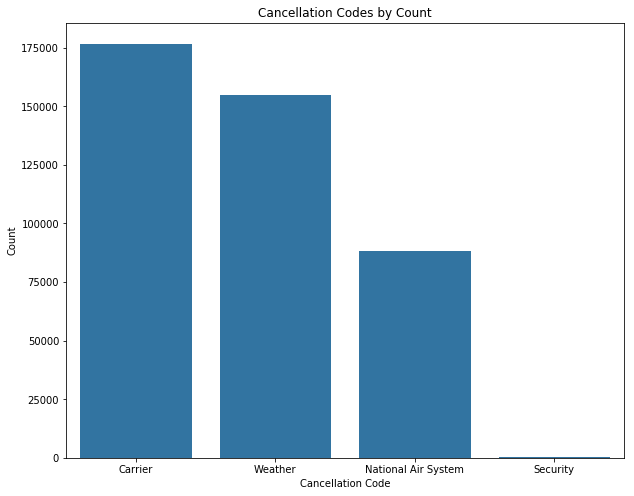

In [8]:
def chart_labels(x_label,y_label,title):
    plt.title(title)
    plt.xlabel(x_label)
    plt.ylabel(y_label)

#Getting distribution using Seaborn bar plot 

#Define Plot
plt.figure(figsize=(10,8))
base_color=sb.color_palette()[0]
g=sb.countplot(data=df_data,x='cancellation_code',color=base_color,order=['A','B','C','D'])
chart_labels('Cancellation Code','Count','Cancellation Codes by Count')
g.set_xticklabels(['Carrier','Weather','National Air System','Security']);

## But which carrier had the most cancellations? 

Envoy Air (MQ) and American Airlines (AA) performed the worst in terms of cancellations. Envoy Air topped cancellations which was followed by American Airlines and Skywest Airlines. 

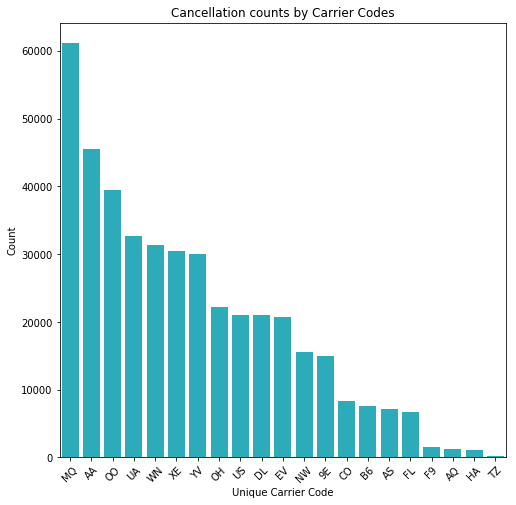

In [9]:
#Getting a subset of original dataframe that contains only cancellation date
df_data_sub=df_data.query('cancellation_code in ["A","B","C","D"]')

#Getting distribution of carriers that had most cancellations

#Saving value counts for various carriers 
carriers_cancellations=df_data_sub.unique_carrier_code.value_counts()

#Define Plot
base_color=sb.color_palette()[9]
plt.figure(figsize=(8,8))
g=sb.countplot(data=df_data_sub,x='unique_carrier_code',color=base_color,order=carriers_cancellations.index)
g.set_xticklabels(labels=carriers_cancellations.index,rotation=45)
chart_labels('Unique Carrier Code','Count','Cancellation counts by Carrier Codes')

## How about delays? Did the same carriers also perform bad on delays?

Interestingly, American Airlines also performed worse in arrival delays. It topped among all other carriers which is closely followed by Southwest Airlines. Envoy Airlines ranked third in terms of delays. 

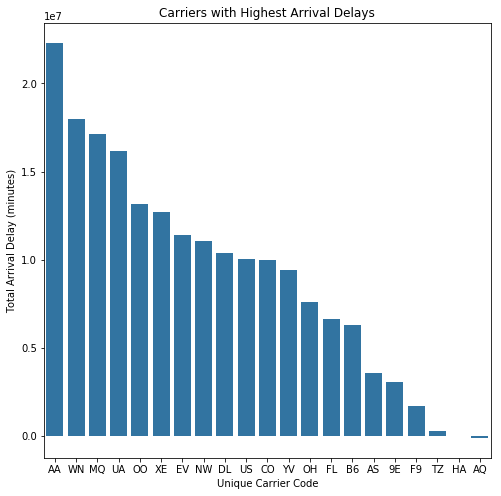

In [12]:
#Filtering only data with arrival_delay information, excluding NaN
df_arrival_delay=df_data[df_data.arrival_delay.notnull()]

#Filtering only data with arrival_delay information, excluding NaN
df_depart_delay=df_data[df_data.departure_delay.notnull()]
#Group by carrier codes and get sum of delayes for each carrier
delays_carrier=df_arrival_delay.groupby('unique_carrier_code').arrival_delay.sum().sort_values(ascending=False)

#Define bar plot

plt.figure(figsize=(12,8))
base_color=sb.color_palette()[0]
sb.barplot(x=delays_carrier.index,y=delays_carrier.values,color=base_color)
chart_labels('Unique Carrier Code','Total Arrival Delay (minutes)','Carriers with Highest Arrival Delays')

## How did each carrier perform in the three years we analyzed?

We can plot their individual performance and show the percentage of flights that each had delayed. ATA Airlines (TZ) and Northwest Airlines (NW) had the most percent of their flights delayed. 

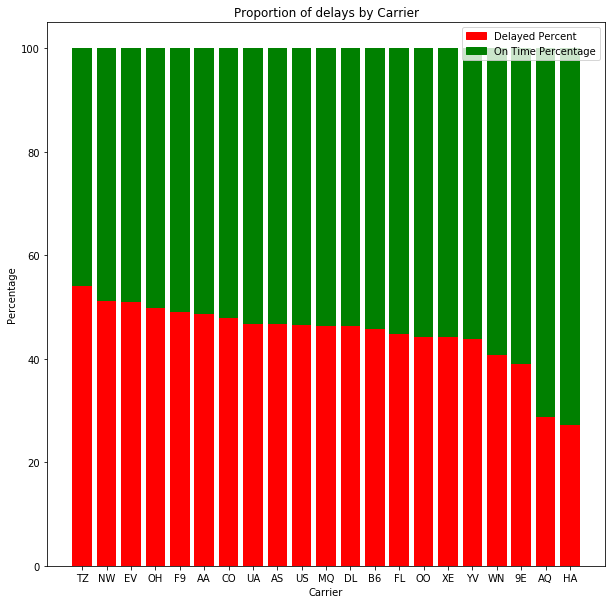

In [19]:
#Getting a dataframe with number of flights that were delayed and not cancelled by each carrier
arrival_delayed=df_depart_delay.query('cancelled==0 & arrival_delay>0').groupby('unique_carrier_code').size().reset_index(name='delayed_flights')

#Getting a dataframe with number of total flights that took off (not cancelled)
uncancelled_flights=df_data.query('cancelled==0').groupby('unique_carrier_code').size().reset_index(name='total_flights')

#Merging both dataframes on unique_carrier_code
df_merged_delay=pd.merge(arrival_delayed,uncancelled_flights,on='unique_carrier_code')

#Calculating the percentage of delayed flights
df_merged_delay['delayed_percent']=df_merged_delay['delayed_flights']/df_merged_delay['total_flights']*100

#Creating a new column on time percentage
df_merged_delay['on_time_percent']=100-df_merged_delay.delayed_percent
df_merged_delay=df_merged_delay.sort_values(by='delayed_percent',ascending=False)

#Define plot
plt.figure(figsize=(10,10))
plt.bar(data=df_merged_delay,x='unique_carrier_code',height='on_time_percent',color='green',bottom=df_merged_delay.delayed_percent)
plt.bar(data=df_merged_delay,x='unique_carrier_code',height='delayed_percent',color='red')
red_patch=mpatches.Patch(color='red',label='Delayed Percent')
green_patch=mpatches.Patch(color='green',label='On Time Percentage')
chart_labels('Carrier','Percentage','Proportion of delays by Carrier')
plt.legend(handles=[red_patch,green_patch]);


## What was the major cause of delays for these years? What was the trend? 

Weather and late aircraft related delays were the biggest causes of delays. The weather delay variation can be attributed to changes in weather conditions.

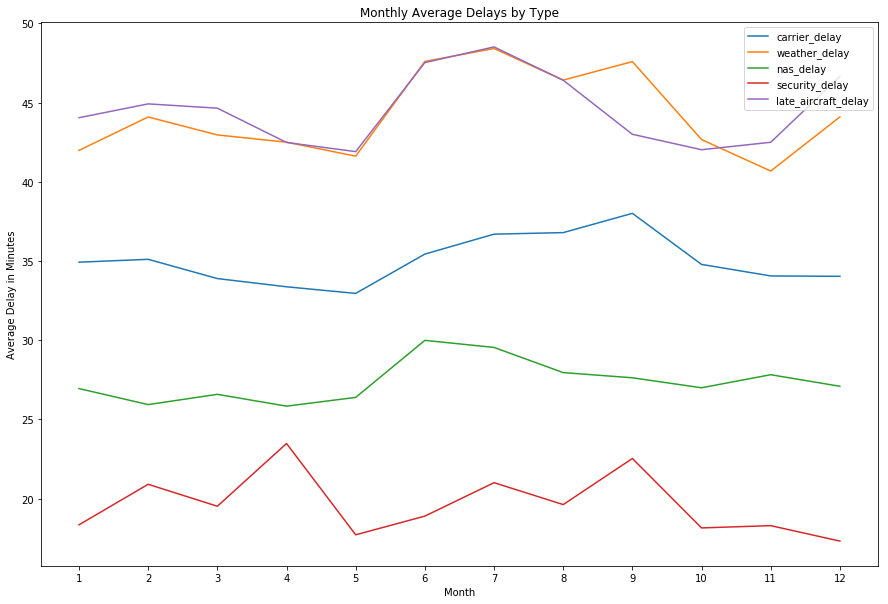

In [15]:
#Creating dataframes that will group each delay by month and calculate average delay for each
carrier_by_month=df_data.query('carrier_delay>0').groupby('month')['carrier_delay'].mean().reset_index(name='carrier_delay')
weather_by_month=df_data.query('weather_delay>0').groupby('month')['weather_delay'].mean().reset_index(name='weather_delay')
nas_by_month=df_data.query('nas_delay>0').groupby('month')['nas_delay'].mean().reset_index(name='nas_delay')
security_by_month=df_data.query('security_delay>0').groupby('month')['security_delay'].mean().reset_index(name='security_delay')
lateaircraft_by_month=df_data.query('late_aircraft_delay>0').groupby('month')['late_aircraft_delay'].mean().reset_index(name='late_aircraft_delay')

#Joining all these dataframes into one
temp=carrier_by_month.merge(weather_by_month,on='month')
temp=temp.merge(nas_by_month,on='month')
temp=temp.merge(security_by_month,on='month')
delays_by_month=temp.merge(lateaircraft_by_month,on='month')

#Define line plot

plt.figure(figsize=(15,10))
plt.errorbar(x=delays_by_month.month,y=delays_by_month.carrier_delay)
plt.errorbar(x=delays_by_month.month,y=delays_by_month.weather_delay)
plt.errorbar(x=delays_by_month.month,y=delays_by_month.nas_delay)
plt.errorbar(x=delays_by_month.month,y=delays_by_month.security_delay)
plt.errorbar(x=delays_by_month.month,y=delays_by_month.late_aircraft_delay)
plt.legend(loc='upper right')

chart_labels('Month','Average Delay in Minutes','Monthly Average Delays by Type')
plt.xticks(delays_by_month.month);

## Summary & Conclusions

- Carrier and weather related cancellations were most common. 

- American Airlines performed the worst in terms of both delays and cancellations. 

- Weather related delays were more significant as we saw in the comparison of delay reasons. 

- ATA Airlines and Northwest Airlines had the most percentage of their flights delayed from 2006-2008. 